# Host celltype fraction plots

In [1]:
bp = "PRJNA665227"
fastq_folder = f"/home/laura/projects/virus-watch-data/{bp}"

In [2]:
import anndata
import numpy as np
import pandas as pd
import json
import os
import gget
import glob
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
%load_ext blackcellmagic

import scanpy as sc
# sc.set_figure_params(figsize=(6, 6), frameon=False)
# sc.settings.n_jobs=2

# Path to Krona tool
ktImportText = "/home/laura/bin/ktImportText"

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

Sat Dec  2 15:20:31 2023 INFO Generating grammar tables from /home/laura/anaconda3/lib/python3.9/site-packages/blib2to3/Grammar.txt
Sat Dec  2 15:20:31 2023 INFO Writing grammar tables to /home/laura/.cache/black/21.12b0/Grammar3.9.12.final.0.pickle
Sat Dec  2 15:20:31 2023 INFO Writing failed: [Errno 2] No such file or directory: '/home/laura/.cache/black/21.12b0/tmp1dvcghgd'
Sat Dec  2 15:20:31 2023 INFO Generating grammar tables from /home/laura/anaconda3/lib/python3.9/site-packages/blib2to3/PatternGrammar.txt
Sat Dec  2 15:20:31 2023 INFO Writing grammar tables to /home/laura/.cache/black/21.12b0/PatternGrammar3.9.12.final.0.pickle
Sat Dec  2 15:20:31 2023 INFO Writing failed: [Errno 2] No such file or directory: '/home/laura/.cache/black/21.12b0/tmpvtaf3ilu'


___
# Load data

In [3]:
host_adata = anndata.read(f"{fastq_folder}/full_index_stringent_dlist_flank1/macaque_QC_norm_leiden_celltypes.h5ad")
host_adata

AnnData object with n_obs × n_vars = 202525 × 66553
    obs: 'sample_barcode', 'barcode', 'srr', 'n_counts', 'n_genes', 'percent_mito', 'species', 'Run', 'donor_animal', 'Experiment', 'mdck_spike_in', 'hours_post_innoculation', 'day_post_infection', 'dpi', 'dpi_accessions', 'dpi_clean', 'leiden', 'celltype_clusters', 'celltype', 'dpi_clean_merged'
    var: 'gene_id', 'species', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_symbol'
    uns: 'dendrogram_leiden', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Get marker genes:

In [4]:
marker_df = pd.read_csv("marker_list.csv")

In [8]:
# Get Ensembl IDs from gene symbols using gget
search_results = gget.search(marker_df["gene_symbol"].values, species="macaca_mulatta", release=109)
# Filter gget results for exact matches and protein-coding biotypes
search_results_filtered = search_results[search_results["gene_name"].isin(marker_df["gene_symbol"].values)][search_results["biotype"]=="protein_coding"]

Sat Dec  2 15:21:41 2023 INFO Fetching results from database: macaca_mulatta_core_109_10
Sat Dec  2 15:22:14 2023 INFO Total matches found: 64.
Sat Dec  2 15:22:14 2023 INFO Query time: 37.54 seconds.


In [9]:
ensembl_id_list = []
for i, gene_symbol in enumerate(marker_df["gene_symbol"].values):
    ensembl_ids = search_results_filtered[search_results_filtered["gene_name"] == gene_symbol]["ensembl_id"].values
    
    if len(ensembl_ids) < 1:
        if gene_symbol.startswith("ENS"):
            ensembl_id_list.append([gene_symbol])
        else:
            print(f"An Ensembl ID for gene {gene_symbol} could not be found.")
            ensembl_id_list.append(np.NaN)
            
    else:
        ensembl_id_list.append(ensembl_ids)

marker_df["ensembl_id_list"] = ensembl_id_list

# Only keep first ID
ensembl_id_list_final = []
for id_list in ensembl_id_list:
    try:
        ensembl_id_list_final.append(id_list[0])
    # If already nan, keep nan
    except:
        ensembl_id_list_final.append(np.NaN)
        
marker_df["ensembl_id"] = ensembl_id_list_final

marker_df

,celltype,gene_name,gene_symbol,ensembl_id_list,ensembl_id
0,B cells,MS4A1,MS4A1,[ENSMMUG00000001260],ENSMMUG00000001260
1,B cells,CD19,CD19,[ENSMMUG00000006880],ENSMMUG00000006880
2,B cells,CD79B,CD79B,[ENSMMUG00000041327],ENSMMUG00000041327
3,Dendritic cells,IRF8,IRF8,[ENSMMUG00000008125],ENSMMUG00000008125
4,Dendritic cells,CD1C,CD1C,[ENSMMUG00000010626],ENSMMUG00000010626
5,Panleukocyte,CD45,PTPRC,[ENSMMUG00000000009],ENSMMUG00000000009
6,Monocytes,FCGR3,ENSMMUG00000016206,[ENSMMUG00000016206],ENSMMUG00000016206
7,Monocytes,HLA-DRB5,HLA-DRB5,[ENSMMUG00000029799],ENSMMUG00000029799
8,Monocytes,HLA-DRA,HLA-DRA,[ENSMMUG00000039082],ENSMMUG00000039082
9,Monocytes,CD68,CD68,[ENSMMUG00000013501],ENSMMUG00000013501


___
# Create fraction plots

In [10]:
# Sort celltype labels using categorical data type
celltype_order = [
    "B cells 1",
    "B cells 2",
    "B cells 3",
    "B cells 4",
    "B cells 5",
    "B cells 6",
    "B cells 7",
    "T cells 1",
    "T cells 2",
    "T cells 3",
    "T cells 4",
    "T cells 5",
    "Natural killer 1",
    "Monocytes 1",
    "Monocytes 2",
    "Immature neutrophils 1",
    "Undefined 1",
    "Undefined 2",
    "Undefined 3"
]
host_adata.obs["celltype_clusters"] = host_adata.obs["celltype_clusters"].cat.reorder_categories(list(celltype_order))

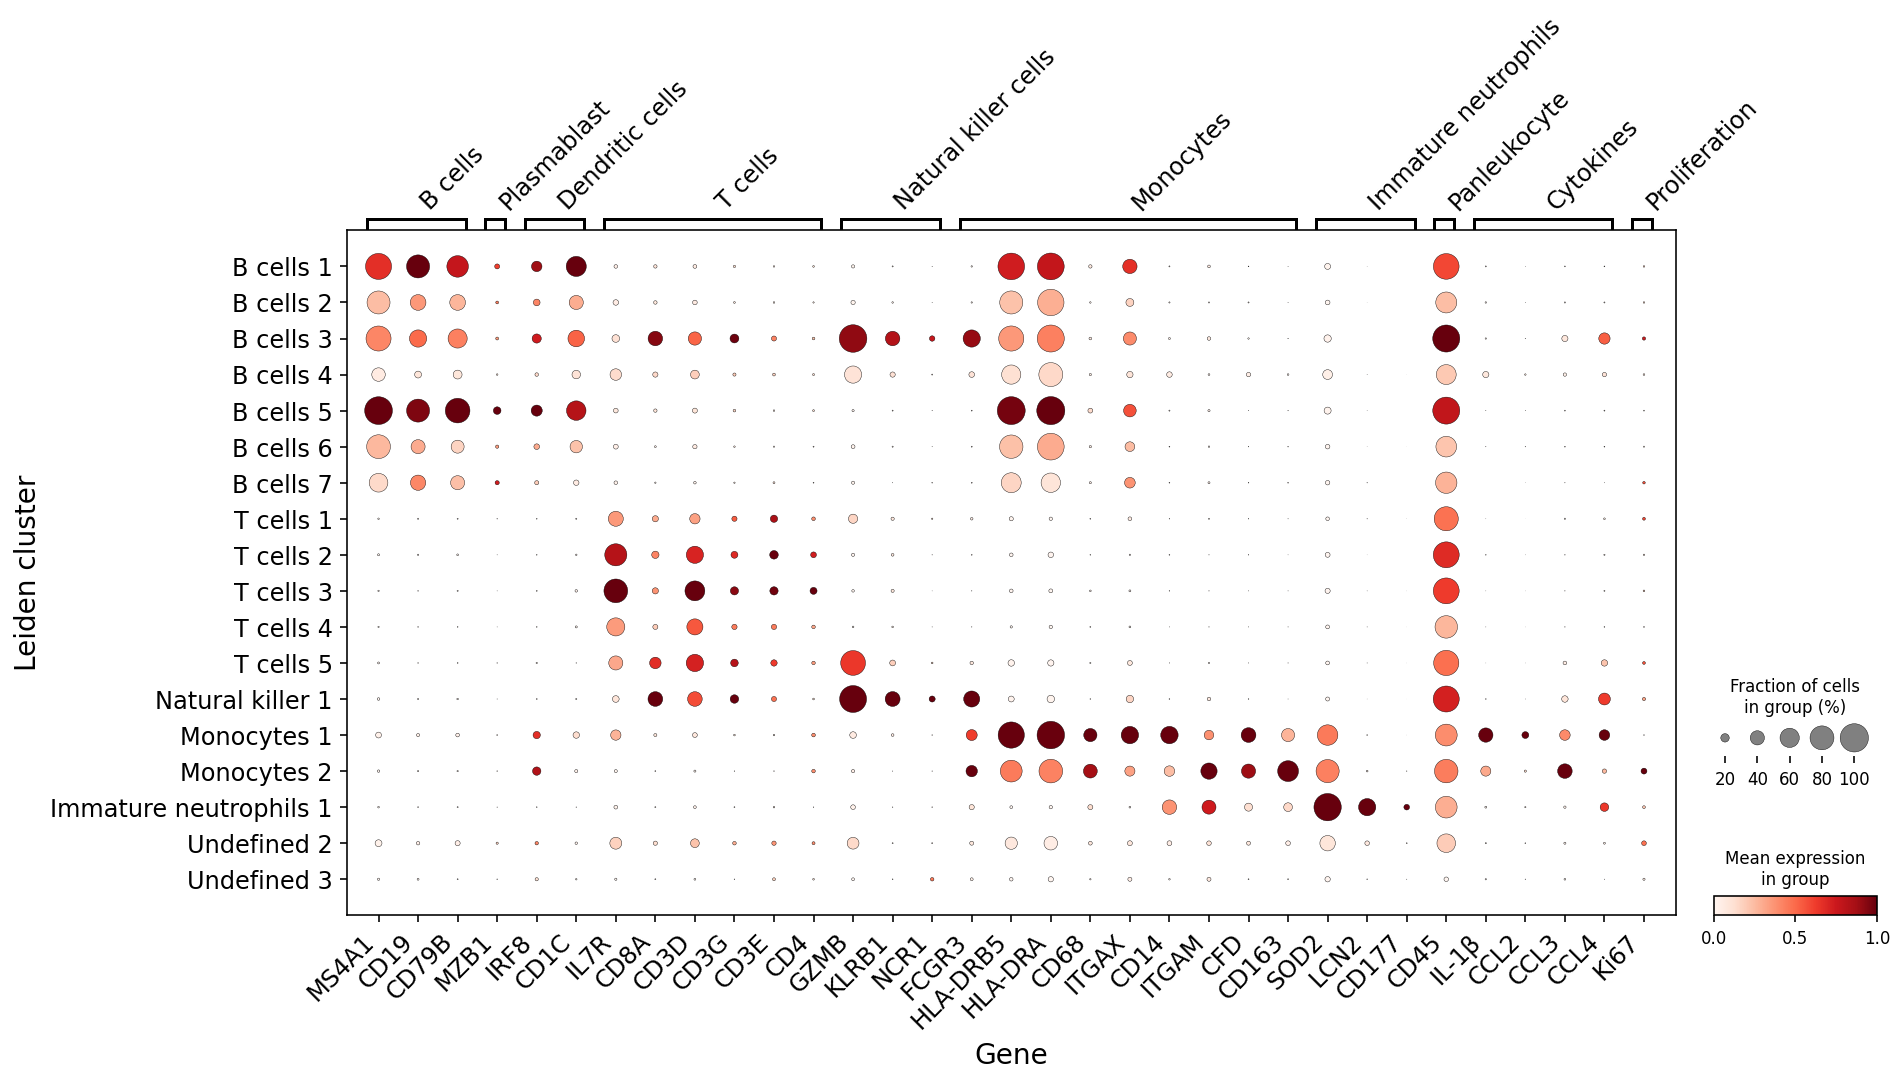

In [11]:
fontsize = 12

celltypes = [
    "B cells",
    "Plasmablast",
    "Dendritic cells",
    "T cells",
    "Natural killer cells",
    "Monocytes",
    "Immature neutrophils",
    "Panleukocyte",
    "Cytokines",
    "Proliferation"
]
# Grab markers in order of celltypes
markers = []
x_labels = []
for celltype in celltypes:
    markers = markers + list(
        marker_df.iloc[marker_df.index[marker_df["celltype"] == celltype].tolist()][
            "ensembl_id"
        ].values
    )
    x_labels = x_labels + list(
        marker_df.iloc[marker_df.index[marker_df["celltype"] == celltype].tolist()][
            "gene_name"
        ].values
    )
# Define celltype gene groups
var_groups = []
start = 0
for celltype in celltypes:
    c_indeces = marker_df.index[marker_df["celltype"] == celltype].tolist()
    var_groups.append((start, start + (c_indeces[-1] - c_indeces[0])))
    start = start + (c_indeces[-1] - c_indeces[0]) + 1

temp_var_labels = [""] * len(celltypes)

ax = sc.pl.dotplot(
    host_adata[~(host_adata.obs["celltype_clusters"] == "Undefined 1"), :], # !!! Removing Undefined 1 because it only has 12 cells
    markers,
    groupby="celltype_clusters",
    use_raw=True,
    dendrogram=False,
    var_group_positions=var_groups,
    var_group_labels=temp_var_labels,
    var_group_rotation=45,
    swap_axes=False,
    standard_scale="var",
    show=False,
)

# ax["mainplot_ax"].set_title(f"Expression of marker genes in {'-'.join(adata.obs['tissue'][0].split('/'))} dataset", pad=120)

## Rotate var labels
# Get initial label positions from: ax["gene_group_ax"].properties()["children"]
var_positions = [1.45, 3.45, 4.95, 8.95, 13.45, 19.45, 25.45, 27.45, 29.95, 32.45]
for position, label in zip(var_positions, celltypes):
    ax["gene_group_ax"].text(
        position, 1.1, label, fontsize=fontsize, rotation=45, ha="left"
    )

ax["mainplot_ax"].set_xticklabels(x_labels, rotation=45, ha="right", fontsize=fontsize)
ax["mainplot_ax"].set_xlabel("Gene", fontsize=fontsize+2)
ax["mainplot_ax"].set_ylabel("Leiden cluster", fontsize=fontsize+2)
ax["mainplot_ax"].tick_params(axis="both", labelsize=fontsize)

plt.tight_layout()

# Save plot
plt.savefig(
    f"figures/3.5_host_celltype_cluster_marker-gene-expression.png",
    dpi=300,
    bbox_inches="tight",
)

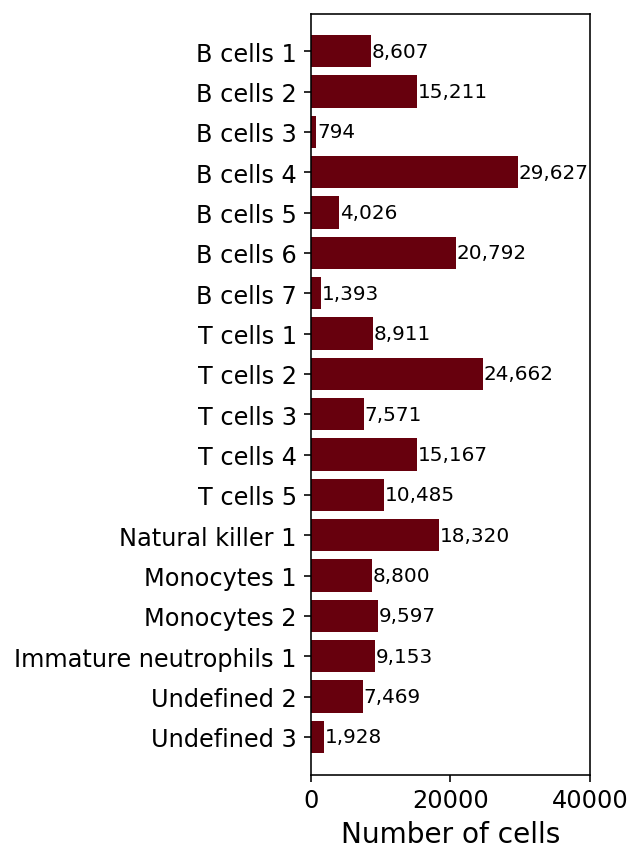

In [12]:
# Plot number of cells per cluster
fig, ax = plt.subplots(figsize = (2.5,7))
fontsize=12

cts = ['B cells 1',
 'B cells 2',
 'B cells 3',
 'B cells 4',
 'B cells 5',
 'B cells 6',
 'B cells 7',
 'T cells 1',
 'T cells 2',
 'T cells 3',
 'T cells 4',
 'T cells 5',
 'Natural killer 1',
 'Monocytes 1',
 'Monocytes 2',
 'Immature neutrophils 1',
 'Undefined 2',
 'Undefined 3'
      ]
cts.reverse()

# Do not plot Undefined clusters
counts = []
for ct in cts:
    counts.append(len(host_adata.obs[host_adata.obs["celltype_clusters"] == ct]))

ax.barh(cts, counts, color="#67000d")

ax.tick_params(axis="both", labelsize=fontsize)
ax.margins(0.03)

# Add number of cells
for i, count in enumerate(counts):
    ax.text(count+100, i, "{:,}".format(count), fontsize=fontsize-2, va="center")
ax.set_xlim(left=0, right=40000)

# ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
# ax.set_axisbelow(True)

ax.set_xlabel("Number of cells", fontsize=fontsize+2)

# Save plot
plt.savefig(
    f"figures/3.5_host_celltype_cluster_numcells.png",
    dpi=300,
    bbox_inches="tight",
)

fig.show()

Plot fractions per celltype:

In [13]:
def plot_fraction_per_sample(
    adata,
    groups="leiden",
    fractions="title",
    colors=None,
    frac_order=None, 
    group_order=None,
    normalize_to_total=False,
    title=None,
    xticklabel_rotation=0,
    figsize=None
):
    ## Save fractions to plot in dataframe
    # # Convert sample column to string (instead of categorical)
    # adata.obs[fractions] = adata.obs[fractions].astype(str)

    df_normalized = pd.DataFrame()

    if normalize_to_total:
        # Normalize each celltype count to total number of cells in that batch by dividing
        df_normalized = ((adata.obs.groupby(groups)[fractions].value_counts()/ adata.obs.groupby(fractions)["species"].count())
            .unstack()
            .fillna(0)
        )
        # Convert columns to string
        df_normalized.columns = df_normalized.columns.astype(str)
        # Get total normalized count
        df_normalized["total_normalized_count"] = df_normalized.sum(axis=1).values

        # Compute fraction of normalized total count for each sample
        for sample in adata.obs[fractions].unique():
            df_normalized[f"{sample}_fraction"] = (df_normalized[sample] / df_normalized["total_normalized_count"]).values

    else:
        # Do not normalize to total count (use if we do not expect these to be equally distributed across the clusters)
        df_normalized = (adata.obs.groupby(groups)[fractions].value_counts().unstack().fillna(0))
        df_normalized["total_count"] = df_normalized.sum(axis=1).values

        for sample in df_normalized.columns[:-1]:
            df_normalized[f"{sample}_fraction"] = (df_normalized[sample] / df_normalized["total_count"]).values

    # Get total cellcount
    df_normalized["total_cellcount"] = (adata.obs.groupby(groups).size().values.astype(int))
    
    # Sort data
    if group_order:
        df_normalized = df_normalized.reindex(group_order)
    else:
        df_normalized = df_normalized.sort_values(list(df_normalized.filter(like='_fraction').columns.values))

    ## Plot
    if figsize:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig, ax = plt.subplots(figsize=(15, 5))
    width = 0.75
    alpha = 1
    fontsize = 14

    clusters = df_normalized.index.values
    cellcounts = df_normalized["total_cellcount"].values
    
    previous_samples = 0
    if frac_order:
        for c_idx, sample in enumerate(frac_order):
            ax.bar(
                clusters,
                df_normalized[f"{sample}_fraction"].values,
                width,
                bottom=previous_samples,
                color=colors[c_idx] if colors else None,
                label=sample,
                alpha=alpha,
            )
            previous_samples = previous_samples + df_normalized[f"{sample}_fraction"].values
    else:
        for c_idx, sample in enumerate(adata.obs[fractions].unique()):
            ax.bar(
                clusters,
                df_normalized[f"{sample}_fraction"].values,
                width,
                bottom=previous_samples,
                color=colors[c_idx] if colors else None,
                label=sample,
                alpha=alpha,
            )
            previous_samples = previous_samples + df_normalized[f"{sample}_fraction"].values

    # Add value above each bar
    for index, value in enumerate(cellcounts):
        ax.text(x=index, y=1.01, s=int(value), size=fontsize - 3, ha="center")

    if xticklabel_rotation == 0:
        ax.set_xticklabels(clusters)
    else:
        ax.set_xticklabels(clusters, rotation=xticklabel_rotation, ha="right")

    ax.legend(bbox_to_anchor=(1.001, 1.025), loc="upper left", fontsize=fontsize)

    ax.set_title(title, y=1.0, pad=20, fontsize=fontsize + 2)
    ax.set_ylabel("Fraction of cells", fontsize=fontsize)
    if "leiden" in groups:
        ax.set_xlabel("Leiden cluster", fontsize=fontsize)
    else:
        ax.set_xlabel(groups.capitalize(), fontsize=fontsize)
    ax.tick_params(axis="both", labelsize=fontsize)

    # ax.axhline(y=0.25, color="grey", linestyle="--")
    # ax.axhline(y=0.5, color="grey", linestyle="--")
    # ax.axhline(y=0.75, color="grey", linestyle="--")

    ax.margins(x=0.01, y=0.06)
    ax.grid(False)

    plt.tight_layout()
    
    if normalize_to_total:
        plt.savefig(
            f"figures/3.5_host_{groups}_{fractions}_norm_fractions.png",
            dpi=300,
            bbox_inches="tight",
        )
    else:
        plt.savefig(
            f"figures/3.5_host_{groups}_{fractions}_fractions.png",
            dpi=300,
            bbox_inches="tight",
        )

    fig.show()

In [14]:
celltype_order.reverse()

/tmp/ipykernel_147745/2068131559.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[f"{sample}_fraction"] = (df_normalized[sample] / df_normalized["total_count"]).values
/tmp/ipykernel_147745/2068131559.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[f"{sample}_fraction"] = (df_normalized[sample] / df_normalized["total_count"]).values
/tmp/ipykernel_147745/2068131559.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

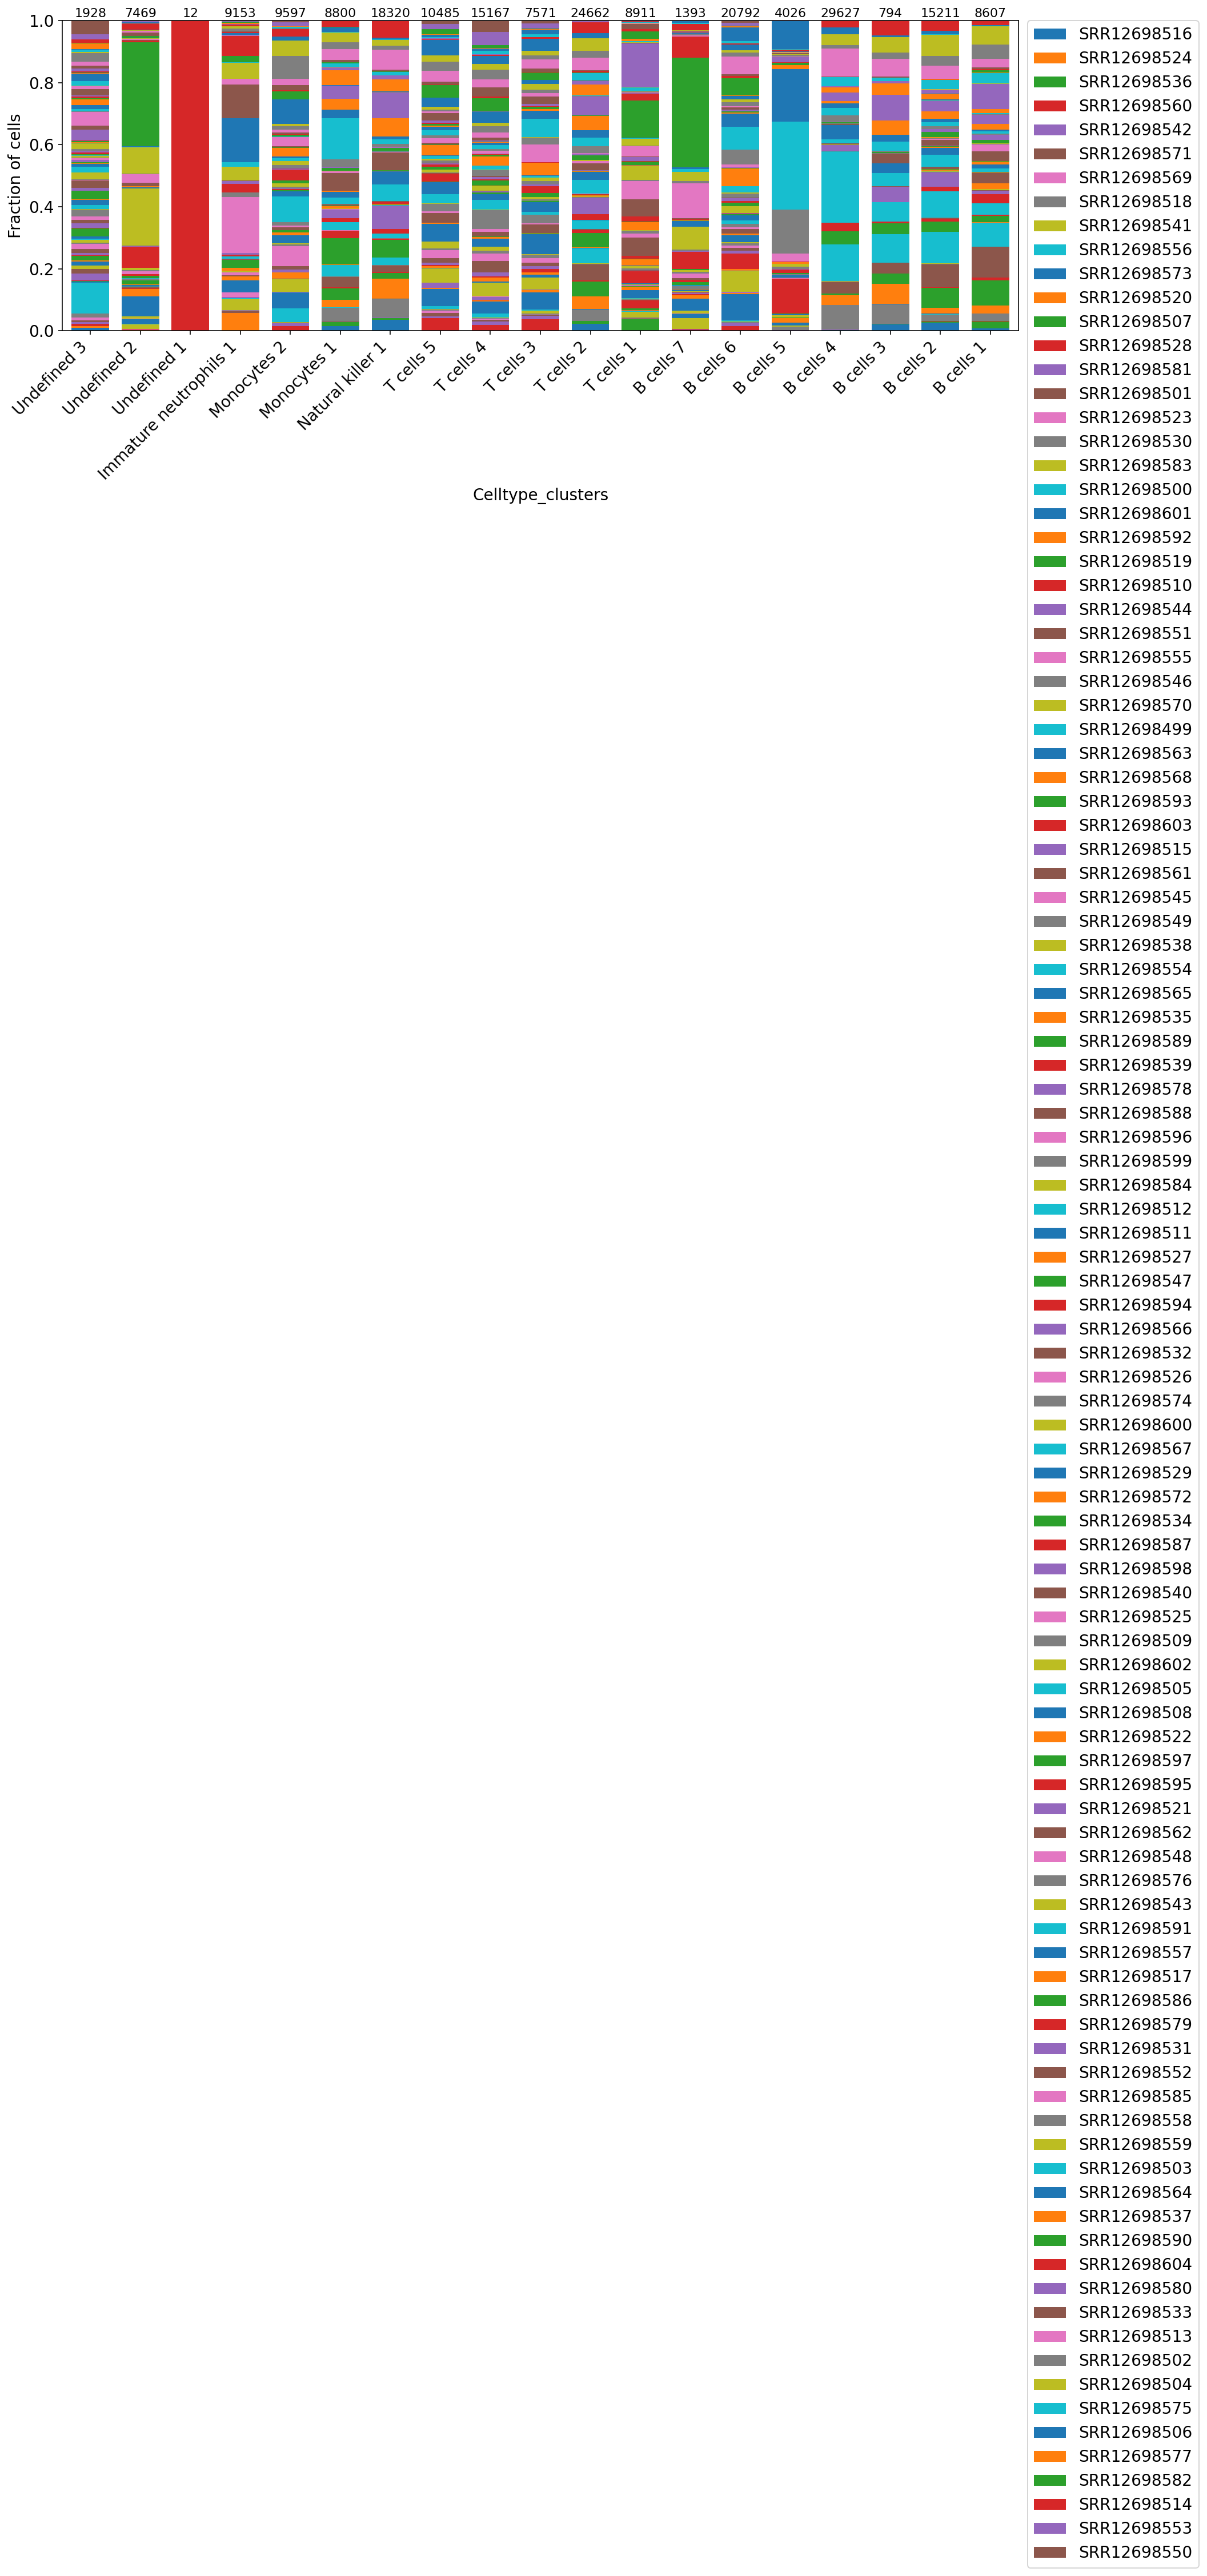

In [15]:
plot_fraction_per_sample(
    host_adata,
    groups="celltype_clusters",
    fractions="srr",
    group_order=celltype_order,
    normalize_to_total=False,
    title=None,
    xticklabel_rotation=45
)

The sequencing libraries did not separate into different clusters (suggesting the lack of a batch effect).

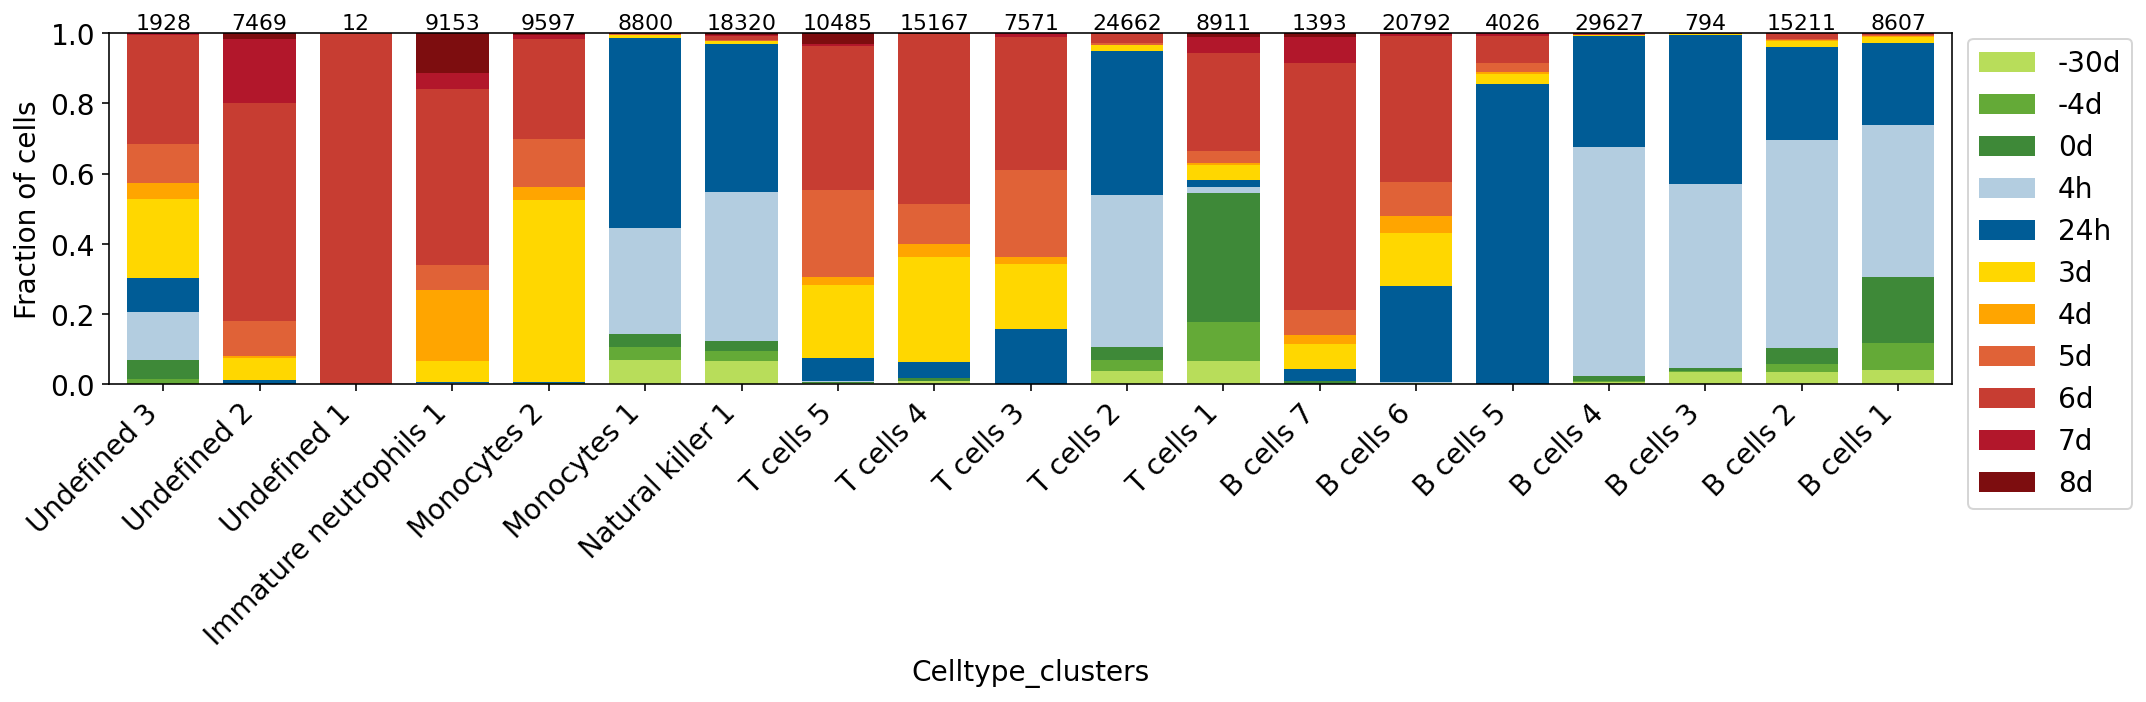

In [16]:
plot_fraction_per_sample(
    host_adata,
    groups="celltype_clusters",
    fractions="dpi_clean",
    colors=["#b8dd5a", "#64aa37", "#3e8938", "#b3cde0", "#005c96", "gold", "orange", "#e06237", "#c73d32", "#b2172b", "#7d0d0f"],
    frac_order=['-30d', '-4d', '0d', '4h', '24h', '3d', '4d', '5d', '6d', '7d', '8d'], 
    group_order=celltype_order,
    normalize_to_total=False,
    title=None,
    xticklabel_rotation=45
)

Same but normalized to total number of cells for each timepoint:

In [62]:
# Convert to string
host_adata.obs["dpi_clean_merged"] = host_adata.obs["dpi_clean_merged"].astype(str)

In [63]:
groups="celltype_clusters"
fractions="dpi_clean_merged"
host_adata.obs.groupby(groups)[fractions].value_counts()/ host_adata.obs.groupby(fractions)["species"].count()

celltype_clusters  dpi_clean_merged
B cells 1          4h                  0.069037
                   24h                 0.039465
                   0d                  0.200898
                   -4d                 0.175274
                   -30d                0.073461
                                         ...   
Undefined 3        0d                  0.012969
                   4d                  0.019045
                   -4d                 0.006521
                   7d/8d               0.001731
                   -30d                0.000849
Length: 174, dtype: float64

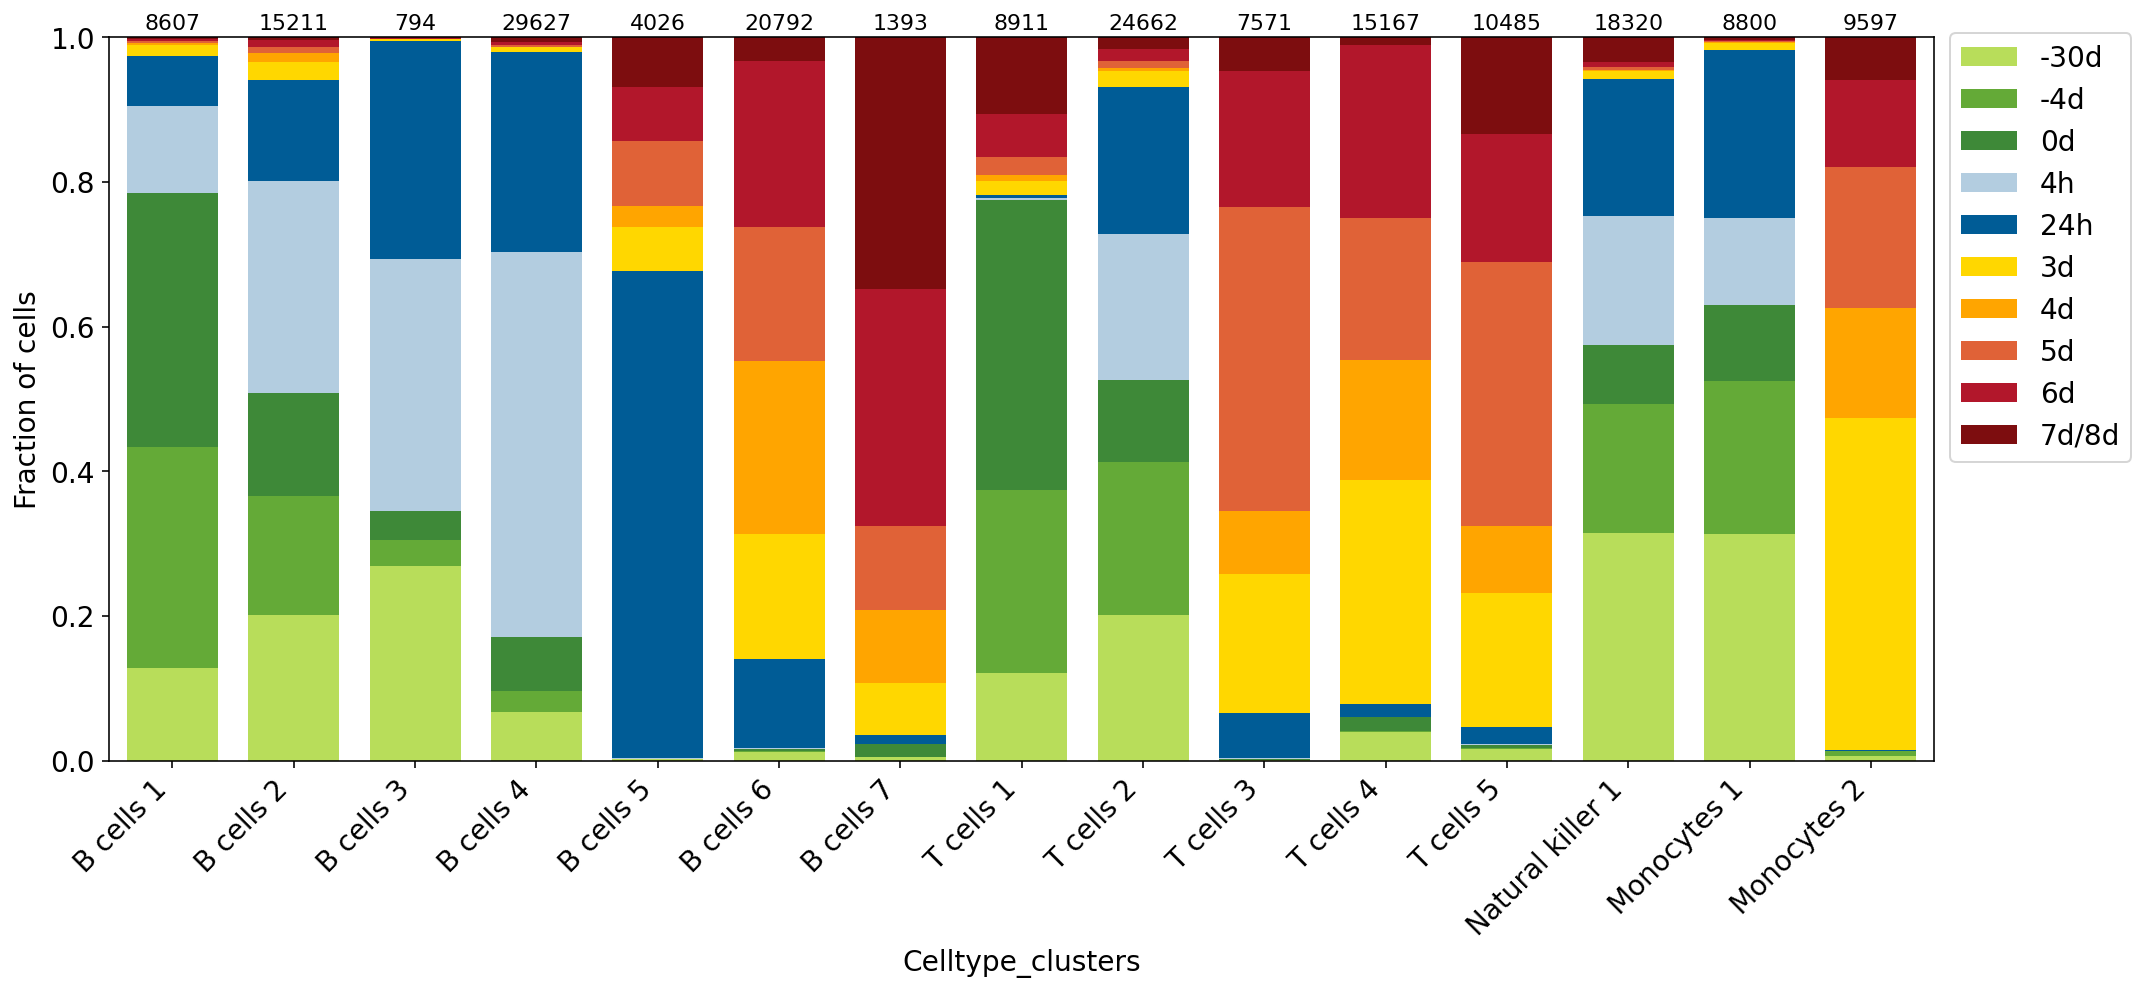

In [64]:
plot_fraction_per_sample(
    host_adata,
    groups="celltype_clusters",
    fractions="dpi_clean_merged",
    colors=["#b8dd5a", "#64aa37", "#3e8938", "#b3cde0", "#005c96", "gold", "orange", "#e06237", "#b2172b", "#7d0d0f"],
    frac_order=['-30d', '-4d', '0d', '4h', '24h', '3d', '4d', '5d', '6d', '7d/8d'], 
    group_order=celltype_order[:-4],
    normalize_to_total=True,
    title=None,
    xticklabel_rotation=45,
    figsize=(15, 7)
)

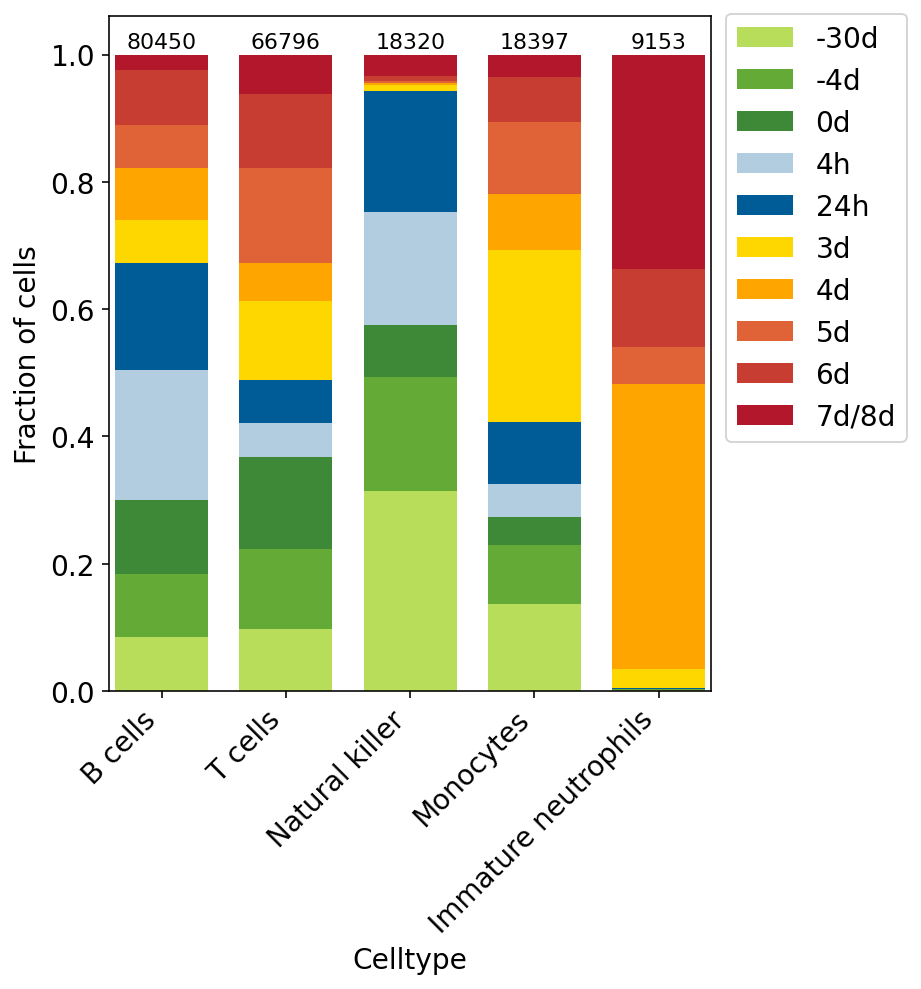

In [65]:
plot_fraction_per_sample(
    host_adata,
    groups="celltype",
    fractions="dpi_clean_merged",
    colors=["#b8dd5a", "#64aa37", "#3e8938", "#b3cde0", "#005c96", "gold", "orange", "#e06237", "#c73d32", "#b2172b", "#7d0d0f"],
    frac_order=['-30d', '-4d', '0d', '4h', '24h', '3d', '4d', '5d', '6d', '7d/8d'], 
    group_order=["B cells", "T cells", "Natural killer",  "Monocytes", "Immature neutrophils"],
    normalize_to_total=True,
    title=None,
    xticklabel_rotation=45,
    figsize=(6.5, 7)
)